# COMP-8130 Project: Investigating Long-Time Contributor Retention in Open-Source Communities Results
By: Najia Shinneeb

Open source software (OSS) is essential to modern software development but poses challenges, including the potential loss of contributors over time. Many OSS projects rely on volunteer contributors, particularly long-time contributors (LTCs), who often contribute without financial compensation. Zhou et al. define an LTC as a contributor who has actively participated in a project for more three years. This project aims to replicate and expand on the study by Bao et al. (2019), utilizing data mining, machine learning, and sentiment analysis techniques to predict which contributors are likely to become LTCs in GitHub OSS projects.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    roc_auc_score
)

# Upload four feature tables
FILE_PATH = "drive/MyDrive/COMP8130-Project/dataset/"

# Get feature table and sort by date
df = pd.read_csv(f"{FILE_PATH}LTC_merged.csv")
df = df.sort_values(by="registration_date")

display(df.head())
print(df.shape)

,repo_name,repo_id,user_id,language,user_age,registration_date,user_own_repos,user_watch_repos,user_contribute_repos,user_history_commits,...,before_repo_issue_events_assigned,before_repo_pull_requests,before_repo_pull_request_comments,before_repo_pull_request_history,before_repo_pull_request_history_merged,before_repo_pull_request_history_closed,before_repo_watchers,ltc_1,ltc_2,ltc_3
0,cpython,81598961,7396,Python,56,2008-06-10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,protobuf,23357588,17011,C++,31,2008-08-14,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,redis,156018,65632,C,0,2009-03-22,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
3,redis,156018,15117,C,269,2009-03-23,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,redis,156018,67219,C,0,2009-03-26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(22002, 65)


In [ ]:
# Count of each repository name
repo_name_counts = df["repo_name"].value_counts()
print("Repository Name Counts:")
display(repo_name_counts)

print("Mean Repository Name Counts:")
mean = round(df["repo_name"].value_counts().mean(), 2)
low = round(df["repo_name"].value_counts().min(), 2)
high = round(df["repo_name"].value_counts().max(), 2)
print(f"Mean contributor count {mean}.")
print(f"Lowest contributor count {low}.")
print(f"Highest contributor count {high}.")

# Count how many repositories use each language
unique_repos = df.drop_duplicates(subset="repo_name")
language_counts = unique_repos["language"].value_counts()
print("Repository Language Counts (Grouped by Unique Repo Name):")
display(language_counts)

label_encoder = LabelEncoder()
languages = df["language"]
df["language_encoded"] = label_encoder.fit_transform(languages)

# Get features
X = df.drop(["repo_name", "repo_id", "user_id", "language", "registration_date", "ltc_1", "ltc_2", "ltc_3",], axis=1)
display(X.head())
y1 = df["ltc_1"]
y2 = df["ltc_2"]
y3 = df["ltc_3"]

display(y1.value_counts())
display(y2.value_counts())
display(y3.value_counts())

Repository Name Counts:


,count
repo_name,
create-react-app,429
ansible,368
javascript,367
youtube-dl,365
moby,364
...,...
developer-roadmap,8
funNLP,8
HowToCook,6


Mean Repository Name Counts:
Mean contributor count 194.71.
Lowest contributor count 1.
Highest contributor count 429.
Repository Language Counts (Grouped by Unique Repo Name):


,count
language,
TypeScript,25
JavaScript,20
Python,19
C++,11
Go,9
Java,6
Rust,5
C,5
Shell,4


,user_age,user_own_repos,user_watch_repos,user_contribute_repos,user_history_commits,user_history_pull_requests,user_history_issues,user_history_followers,month_user_commits,month_user_commit_comments,...,before_repo_issue_events,before_repo_issue_events_closed,before_repo_issue_events_assigned,before_repo_pull_requests,before_repo_pull_request_comments,before_repo_pull_request_history,before_repo_pull_request_history_merged,before_repo_pull_request_history_closed,before_repo_watchers,language_encoded
0,56,1,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,10
1,31,0,0,0,0,0,0,0,88,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,67,0,...,0,0,0,0,0,0,0,0,0,0
3,269,1,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


,count
ltc_1,
0,16665
1,5337


,count
ltc_2,
0,18937
1,3065


,count
ltc_3,
0,19905
1,2097


User age stats: 
Mean user age when ltc_1 = 1: 1576.492786209481
Mean user age when ltc_1 = 0: 1607.6117611761176
Mean user age when ltc_2 = 1: 1559.7663947797716
Mean user age when ltc_2 = 0: 1606.5854147964303


In [ ]:
print("User age stats:\n")
def print_stats(col_name, label):
    subset = df[df[col_name] == label]["user_age"]
    print(f"[{col_name} = {label}] Mean: {subset.mean():.2f}, Max: {subset.max()}, Min: {subset.min()}, Std: {subset.std():.2f}")

# ltc_1
print_stats("ltc_1", 1)
print_stats("ltc_1", 0)

# ltc_2
print_stats("ltc_2", 1)
print_stats("ltc_2", 0)

# ltc_3
print_stats("ltc_3", 1)
print_stats("ltc_3", 0)

User age stats:

[ltc_1 = 1] Mean: 1576.49, Max: 4645, Min: 0, Std: 955.89
[ltc_1 = 0] Mean: 1607.61, Max: 4703, Min: 0, Std: 947.26
[ltc_2 = 1] Mean: 1559.77, Max: 4645, Min: 0, Std: 969.54
[ltc_2 = 0] Mean: 1606.59, Max: 4703, Min: 0, Std: 946.00
[ltc_3 = 1] Mean: 1583.23, Max: 4645, Min: 0, Std: 979.52
[ltc_3 = 0] Mean: 1601.84, Max: 4703, Min: 0, Std: 946.21


In [ ]:
print("\nUser owned repositories stats:\n")
def print_stats_repos(col_name, label):
    subset = df[df[col_name] == label]["user_own_repos"]
    print(f"[{col_name} = {label}] Mean: {subset.mean():.2f}, Max: {subset.max()}, Min: {subset.min()}, Std: {subset.std():.2f}")

# ltc_1
print_stats_repos("ltc_1", 1)
print_stats_repos("ltc_1", 0)

# ltc_2
print_stats_repos("ltc_2", 1)
print_stats_repos("ltc_2", 0)

# ltc_3
print_stats_repos("ltc_3", 1)
print_stats_repos("ltc_3", 0)



User owned repositories stats:

[ltc_1 = 1] Mean: 31.57, Max: 3964, Min: 0, Std: 89.01
[ltc_1 = 0] Mean: 35.07, Max: 9317, Min: 0, Std: 126.20
[ltc_2 = 1] Mean: 31.17, Max: 3964, Min: 0, Std: 105.52
[ltc_2 = 0] Mean: 34.72, Max: 9317, Min: 0, Std: 120.19
[ltc_3 = 1] Mean: 31.12, Max: 2012, Min: 0, Std: 88.43
[ltc_3 = 0] Mean: 34.55, Max: 9317, Min: 0, Std: 120.98


Check mapping.

In [ ]:
print(df[["language_encoded", "language"]].to_string())

       language_encoded    language
0                    10      Python
1                     2         C++
2                     0           C
3                     0           C
4                     0           C
5                     7          Go
6                     0           C
7                    10      Python
8                     0           C
9                     9  JavaScript
10                    9  JavaScript
11                   10      Python
12                   12       Shell
13                   12       Shell
14                   12       Shell
15                   10      Python
16                   12       Shell
17                    7          Go
18                   12       Shell
19                   12       Shell
20                   12       Shell
21                   12       Shell
22                   12       Shell
23                    7          Go
24                    7          Go
25                    7          Go
26                    7     

Merge all four feature tables.

## PART 1: Perform Machine Learning Evaluation for LTC 1, 2, & 3
- Function to evaluate models with time-based splits.
- Standardizes all features.
- Trains Naive Bayes, SVM, Decision Tree, Random Forest, and kNN models.
- Computers ROC AUC scores and feature importance.

In [ ]:
def evaluate_ltc(X, Y):
  # Sort dataset into 10 equal time-based windows
  window_size = len(X) // 10
  windows_X = [X.iloc[i * window_size:(i + 1) * window_size] for i in range(10)]
  windows_Y = [Y.iloc[i * window_size:(i + 1) * window_size] for i in range(10)]

  # Initialize classifiers
  models = {
      "Naive Bayes": GaussianNB(),
      "SVM": SVC(probability=True, random_state=42),
      "Decision Tree": DecisionTreeClassifier(random_state=42),
      "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
      "kNN": KNeighborsClassifier(n_neighbors=5)
  }

  # Store AUC scores
  auc_scores = {model: [] for model in models}

  # Train models using time-based splits
  for n in range(1, 10):
      # Create training and testing sets
      train_X = pd.concat(windows_X[:n])  # First n windows for training
      test_X = pd.concat(windows_X[n:])   # Remaining (10-n) windows for testing
      train_Y = pd.concat(windows_Y[:n])  # Corresponding labels
      test_Y = pd.concat(windows_Y[n:])   # Corresponding labels

      # Standardize for SVM and kNN
      scaler = StandardScaler()
      train_X_scaled = scaler.fit_transform(train_X)
      test_X_scaled = scaler.transform(test_X)

      # Train and evaluate models
      for name, model in models.items():
          if name in ["SVM", "kNN"]:
              model.fit(train_X_scaled, train_Y)
              y_prob = model.predict_proba(test_X_scaled)[:, 1]
          else:
              model.fit(train_X, train_Y)
              y_prob = model.predict_proba(test_X)[:, 1]

          # Compute AUC
          auc_score = roc_auc_score(test_Y, y_prob)
          auc_scores[name].append(auc_score)

  # Convert AUC results to DataFrame
  auc_df = pd.DataFrame(auc_scores, index=range(1, 10))
  auc_df.index.name = "Training Windows (n)"

  # Calculate mean AUC for each model
  mean_auc = auc_df.mean().to_frame(name="Mean AUC")

  # Print AUC scores as table
  print("\n=== AUC Scores by Training Windows ===")
  print(auc_df)

  # Print mean AUC scores
  print("\n=== Mean AUC Scores ===")
  print(mean_auc)

  # Feature Importance (for Decision Tree & Random Forest)
  for model_name in ["Decision Tree", "Random Forest"]:
      model = models[model_name]
      importances = model.feature_importances_
      feature_names = X.columns

      # Create feature importance DataFrame
      importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
      importance_df = importance_df.sort_values(by="Importance", ascending=False)

      print(f"\n=== {model_name} Feature Importance ===")
      print(importance_df.to_string(index=False))  # Print without index for clean formatting

## Results:

In [ ]:
evaluate_ltc(X, y1)


=== AUC Scores by Training Windows ===
                      Naive Bayes       SVM  Decision Tree  Random Forest  \
Training Windows (n)                                                        
1                        0.738608  0.739430       0.499298       0.672014   
2                        0.750925  0.738576       0.557418       0.738774   
3                        0.756785  0.748012       0.585431       0.771945   
4                        0.760011  0.758040       0.587961       0.782106   
5                        0.761602  0.757323       0.605288       0.782796   
6                        0.757952  0.737713       0.601509       0.787018   
7                        0.755759  0.743823       0.608763       0.795077   
8                        0.758648  0.743001       0.595278       0.784325   
9                        0.733619  0.735353       0.627638       0.820677   

                           kNN  
Training Windows (n)            
1                     0.651847  
2            

In [ ]:
evaluate_ltc(X, y2)


=== AUC Scores by Training Windows ===
                      Naive Bayes       SVM  Decision Tree  Random Forest  \
Training Windows (n)                                                        
1                        0.759782  0.757837       0.545893       0.747014   
2                        0.772811  0.758344       0.556721       0.799911   
3                        0.781365  0.772007       0.582402       0.812834   
4                        0.784449  0.790160       0.589150       0.814156   
5                        0.782414  0.777799       0.644831       0.821155   
6                        0.779456  0.759893       0.604136       0.809901   
7                        0.771042  0.709579       0.614853       0.812569   
8                        0.775147  0.688796       0.604805       0.806963   
9                        0.760769  0.711457       0.633267       0.842387   

                           kNN  
Training Windows (n)            
1                     0.675597  
2            

In [ ]:
evaluate_ltc(X, y3)


=== AUC Scores by Training Windows ===
                      Naive Bayes       SVM  Decision Tree  Random Forest  \
Training Windows (n)                                                        
1                        0.759900  0.755564       0.524492       0.764963   
2                        0.771845  0.748758       0.613766       0.805961   
3                        0.778194  0.779694       0.598981       0.825924   
4                        0.779786  0.785302       0.620057       0.823611   
5                        0.785255  0.752892       0.592930       0.828773   
6                        0.783607  0.656341       0.595747       0.814858   
7                        0.779530  0.611484       0.624690       0.821430   
8                        0.782430  0.645961       0.583134       0.812771   
9                        0.761708  0.672317       0.596767       0.824771   

                           kNN  
Training Windows (n)            
1                     0.657798  
2            

## PART 2: Sentiment Analysis

- Uses commit, push, and issue comments and computed sentiments using VADAR python library.
- Each user receives an average sentiment for comments they get in the first year of joining a repository as well as the number of comments.
- Aim is to see if the number of comments and average sentiment can help detect whether a user will become an LTC.


In [ ]:
def evaluate_comments(X, y):
  # Initialize models
  models = {
      "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
      "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
      "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
      "Naive Bayes": GaussianNB()
  }
  # Train-test split
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
  # Standardization and SMOTE
  scaler = StandardScaler()
  smote = SMOTE(random_state=42)
  X_train_scaled = scaler.fit_transform(X_train)
  X_val_scaled = scaler.transform(X_val)
  X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

  for model_name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_val_scaled)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"Evaluating {model_name}...")
    print(classification_report(y_val, y_pred))

    # ROC AUC
    if y_pred_proba is not None:
      fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
      roc_auc = auc(fpr, tpr)
      print(f"ROC AUC: {roc_auc:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plot_confusion_matrix(cm, y, model_name)

def plot_confusion_matrix(cm, y, model_name):
  fig, ax = plt.subplots()
  cax = ax.matshow(cm, cmap="Blues")
  plt.colorbar(cax)
  for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f"{val}", ha='center', va='center', color='black')
  ax.set_xticks([0, 1])
  ax.set_yticks([0, 1])
  ax.set_xticklabels(["Pred 0", "Pred 1"])
  ax.set_yticklabels(["Actual 0", "Actual 1"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title(f"Confusion Matrix - {model_name}")
  plt.tight_layout()
  plt.show()

In [ ]:
df2 = pd.read_csv(f"{FILE_PATH}LTC_comments.csv")
X = df2[["num_comments", "avg_sentiment"]]

y1, y2, y3 = df2["ltc_1"], df2["ltc_2"], df2["ltc_3"]
display(df2.shape)
display(df2.head())
display(X.value_counts())
display(y1.value_counts())
display(y2.value_counts())
display(y3.value_counts())

count = df["repo_name"].value_counts()
print(f"Repository Counts: ")
display(count)

(4973, 9)

,repo_name,repo_id,contributor_id,date,num_comments,avg_sentiment,ltc_1,ltc_2,ltc_3
0,freeCodeCamp,28457823,18572518,2016-04-20 10:24:58+00:00,399,0.3,1,1,1
1,freeCodeCamp,28457823,10749142,2015-01-28 23:16:30+00:00,90,0.4,0,0,0
2,freeCodeCamp,28457823,6775919,2014-02-24 21:26:33+00:00,1,1.0,1,0,0
3,freeCodeCamp,28457823,13225220,2015-07-07 19:04:30+00:00,242,0.4,0,0,0
4,freeCodeCamp,28457823,51722130,2019-06-11 20:13:34+00:00,38,0.3,1,1,1


num_comments  avg_sentiment
1             1.0              448
2             1.0              188
1             0.0              165
2             0.5              143
              0.0              110
                              ... 
1104          0.3                1
1094          0.2                1
1038          0.4                1
1022          0.3                1
995           0.3                1
Name: count, Length: 1057, dtype: int64

,count
ltc_1,
0,3562
1,1411


,count
ltc_2,
0,4134
1,839


,count
ltc_3,
0,4442
1,531


Repository Counts: 


,count
repo_name,
create-react-app,429
ansible,368
javascript,367
youtube-dl,365
moby,364
...,...
developer-roadmap,8
funNLP,8
HowToCook,6


Evaluating Random Forest...
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      1425
           1       0.50      0.42      0.45       565

    accuracy                           0.71      1990
   macro avg       0.64      0.62      0.63      1990
weighted avg       0.70      0.71      0.71      1990

ROC AUC: 0.64


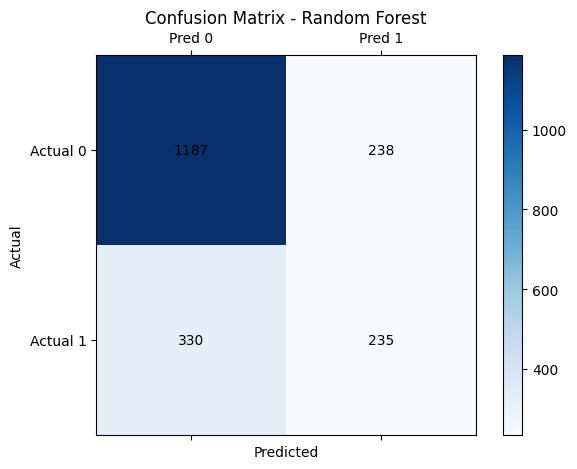

Evaluating Decision Tree...
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1425
           1       0.53      0.38      0.44       565

    accuracy                           0.73      1990
   macro avg       0.66      0.62      0.63      1990
weighted avg       0.71      0.73      0.71      1990

ROC AUC: 0.60


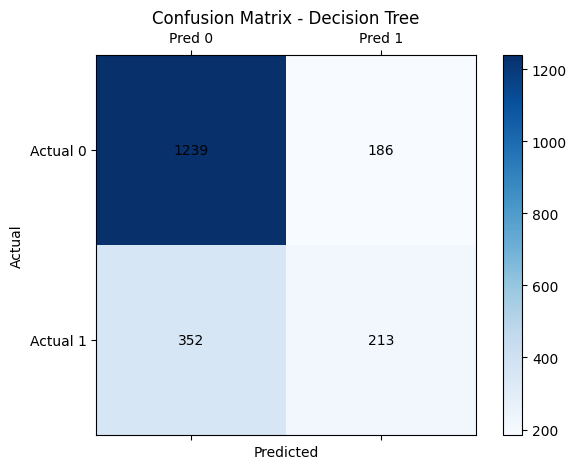

Evaluating Logistic Regression...
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1425
           1       0.55      0.47      0.51       565

    accuracy                           0.74      1990
   macro avg       0.68      0.66      0.67      1990
weighted avg       0.73      0.74      0.73      1990

ROC AUC: 0.74


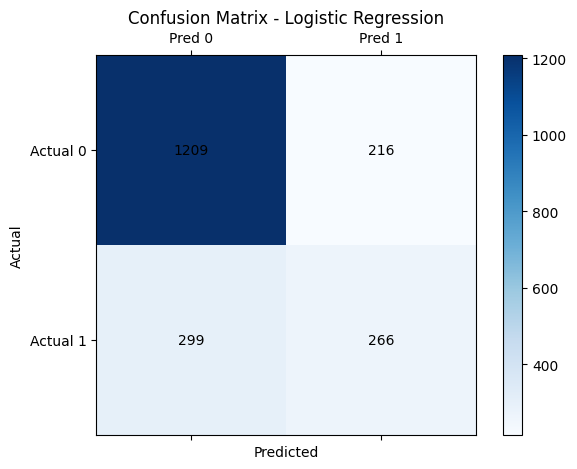

Evaluating Naive Bayes...
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1425
           1       0.69      0.28      0.40       565

    accuracy                           0.76      1990
   macro avg       0.73      0.61      0.62      1990
weighted avg       0.74      0.76      0.72      1990

ROC AUC: 0.71


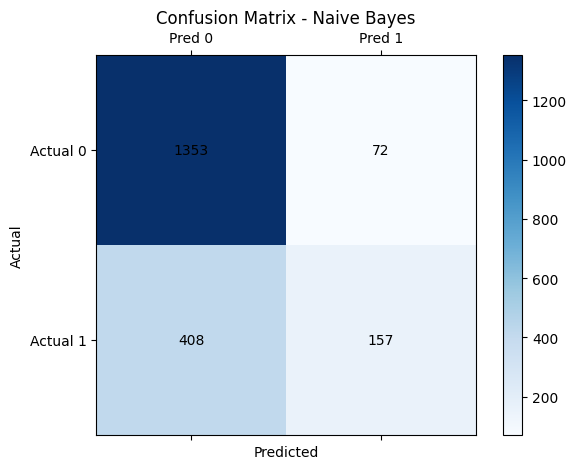

In [ ]:
evaluate_comments(X, y1)

Evaluating Random Forest...
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1654
           1       0.35      0.34      0.35       336

    accuracy                           0.78      1990
   macro avg       0.61      0.61      0.61      1990
weighted avg       0.78      0.78      0.78      1990

ROC AUC: 0.64


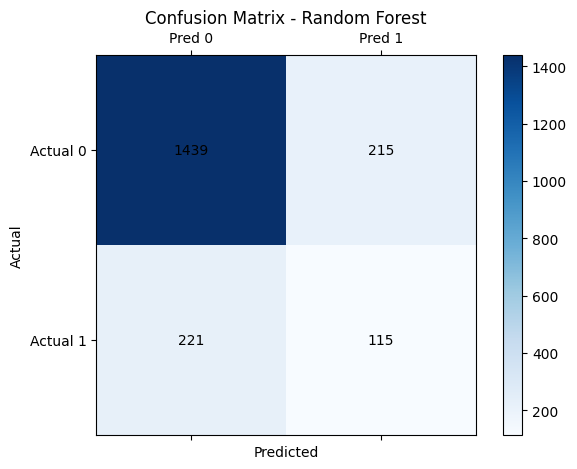

Evaluating Decision Tree...
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1654
           1       0.38      0.32      0.34       336

    accuracy                           0.80      1990
   macro avg       0.62      0.60      0.61      1990
weighted avg       0.78      0.80      0.79      1990

ROC AUC: 0.56


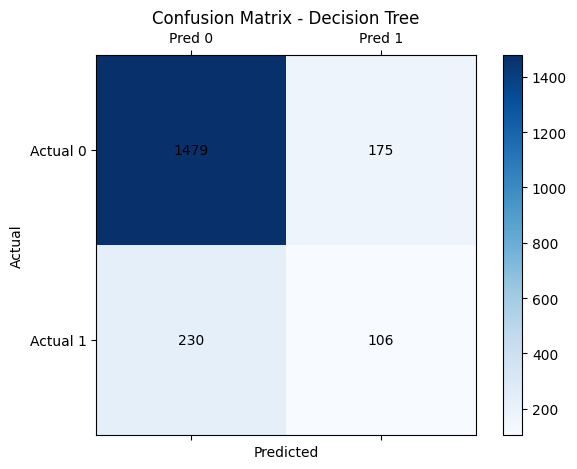

Evaluating Logistic Regression...
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1654
           1       0.34      0.53      0.41       336

    accuracy                           0.74      1990
   macro avg       0.61      0.66      0.62      1990
weighted avg       0.80      0.74      0.76      1990

ROC AUC: 0.73


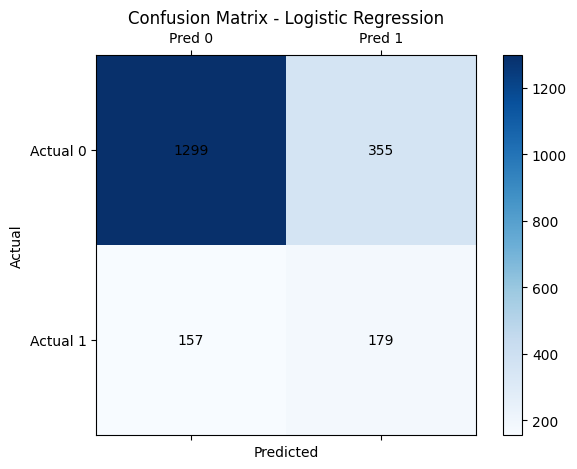

Evaluating Naive Bayes...
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1654
           1       0.59      0.30      0.40       336

    accuracy                           0.85      1990
   macro avg       0.73      0.63      0.66      1990
weighted avg       0.82      0.85      0.83      1990

ROC AUC: 0.74


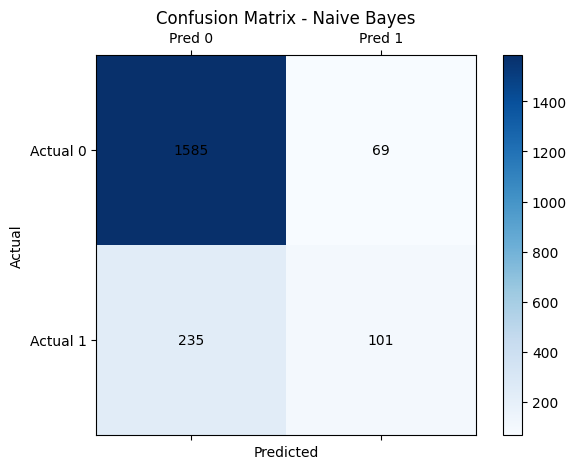

In [ ]:
evaluate_comments(X, y2)

Evaluating Random Forest...
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1778
           1       0.24      0.30      0.27       212

    accuracy                           0.83      1990
   macro avg       0.58      0.59      0.58      1990
weighted avg       0.84      0.83      0.83      1990

ROC AUC: 0.59


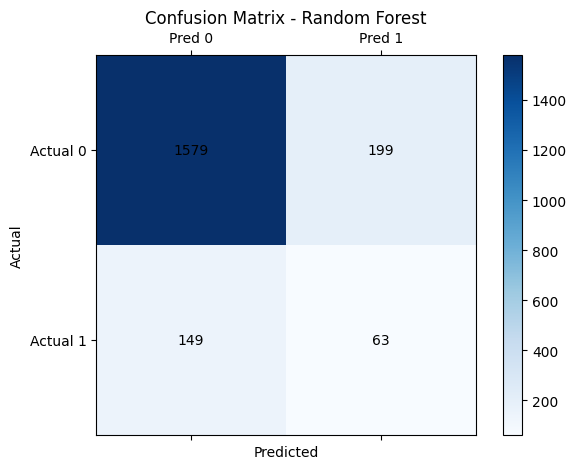

Evaluating Decision Tree...
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1778
           1       0.24      0.26      0.25       212

    accuracy                           0.83      1990
   macro avg       0.58      0.58      0.58      1990
weighted avg       0.84      0.83      0.84      1990

ROC AUC: 0.51


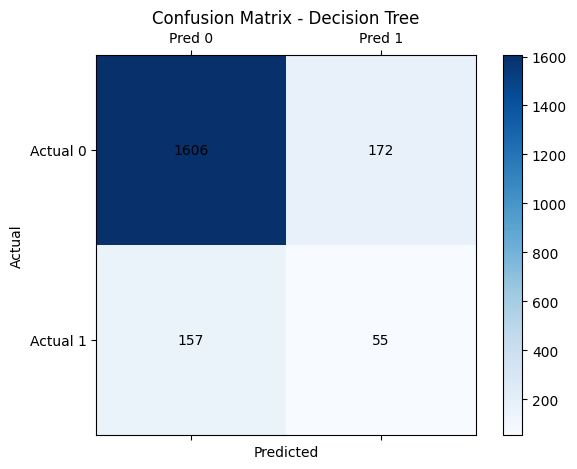

Evaluating Logistic Regression...
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1778
           1       0.23      0.42      0.29       212

    accuracy                           0.79      1990
   macro avg       0.57      0.62      0.58      1990
weighted avg       0.85      0.79      0.81      1990

ROC AUC: 0.70


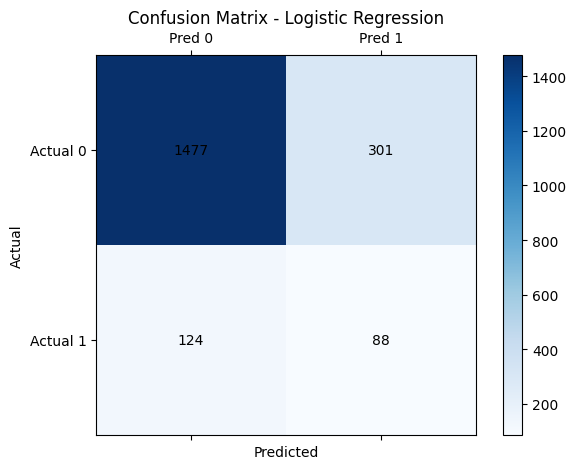

Evaluating Naive Bayes...
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1778
           1       0.37      0.24      0.29       212

    accuracy                           0.87      1990
   macro avg       0.64      0.60      0.61      1990
weighted avg       0.85      0.87      0.86      1990

ROC AUC: 0.71


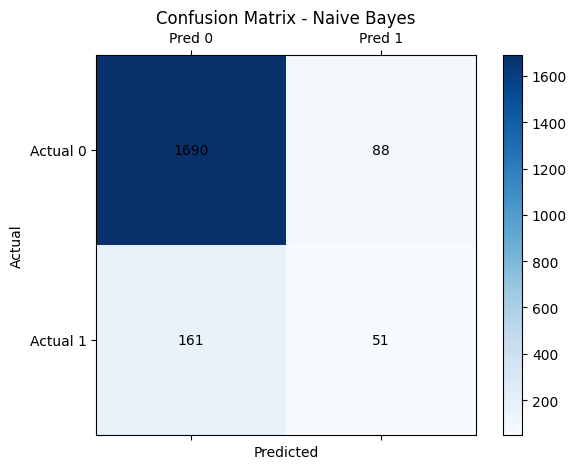

In [ ]:
evaluate_comments(X, y3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')